# Universal Template for Resonant Metasurface Characterization

In [1]:
#--------------<< Standard Python Imports >>-------------------------
import h5py
import matplotlib.pyplot as plt
import numpy as np
#----------------------<< Tidy3d Imports  >>-------------------------
import tidy3d as td
from tidy3d import web

# Simulation Setup

In [2]:
#---------------------<< Define the Frequencies >>----------------------
lam1=1.52
lam2=1.54
Nfreq = 101
wavelengths = np.linspace(lam1, lam2, Nfreq)
freqs = td.constants.C_0 / wavelengths
#-----------<< Define the Frequency Center and Width of Pulse >>--------
freq0 = freqs[len(freqs) // 2]
freqw = freqs[0] - freqs[-1]
#--------------<< Number of Mesh Per Wavelength >>----------------------
Mesh=30
#----------------------------- << Simulation run time>>--------------------------
run_time = 5000e-15

# Material Properties

Local file not found, loading from refractiveindex.info instead...


/Users/yankunmeng/.local/lib/python3.10/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/yankunmeng/.local/lib/python3.10/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/yankunmeng/.local/lib/python3.10/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/yankunmeng/.local/lib/python3.10/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

22:17:31 EDT WARNING: Unable to fit with weighted RMS error under               
             'tolerance_rms' of 1e-05                                           

Fit RMS error: 0.07986558845125251


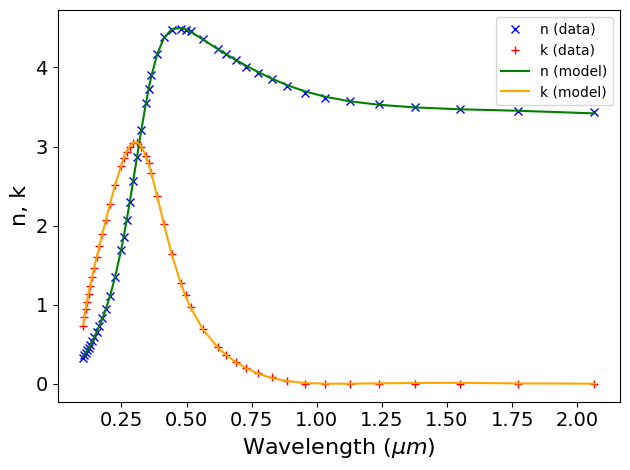

In [3]:
#------<< a Python tool for working with file and folder paths safely across operating systems >>---------
from pathlib import Path
from tidy3d.plugins.dispersion import FastDispersionFitter
#---------------------------<< Refractive index of the  substrate >>--------------------------------------
n_SiO2 = 1.45
SiO2 = td.Medium(permittivity=n_SiO2**2)
#---------------------------<< Refractive index of the  superstrate >>------------------------------------
n_sup = 1.0
Air = td.Medium(permittivity=n_sup**2)
#------------<< Gets the current working directory (the folder where your notebook is running) >>----------
cwd = Path.cwd()
candidates = [
    cwd / "amorphous_silicon_from_paper.txt",  
    cwd / "amorphous_silicon_from_paper",       
    cwd / "misc" / "amorphous_silicon_from_paper.txt",
    cwd / "misc" / "amorphous_silicon_from_paper",
]

fname = next((p for p in candidates if p.exists()), None)

if fname is not None:
    print(f"Found it From Your Ellipsometery: {fname}")
    fitter = FastDispersionFitter.from_file(str(fname))
else:
    print("Local file not found, loading from refractiveindex.info instead...")
    url = "https://refractiveindex.info/tmp/database/data-nk/main/Si/Pierce.txt"
    fitter = FastDispersionFitter.from_url(url, delimiter="\t")
#------------------------------------------<< Fit the Data and Plot it >>-------------------------------------------
silicon, error = fitter.fit(max_num_poles=5, tolerance_rms=1e-5)
print("Fit RMS error:", error)
ax = fitter.plot(silicon)
ax.set_title(ax.get_title(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()

# Geometry of the Meta-Atoms

In [4]:
#------------------<< Height of the Meta-Atom >>------------------
h = 0.1      
#------------------------<< Main Radius >>------------------------
R = 0.305                
#------------------------<< Hole Radius >>------------------------
rh = 0.09                 
#----------------------<< Off-Center Hole >>----------------------
delta=0.1                 
#--------------------<< Meta-Atom Periodicity >>------------------
px = 1                   
py = 1     
#--------------------<< Meta-Atom Rotation >>---------------------
alpha = np.deg2rad(0)

# Simulation Setup:
## 1. Setting Up Monitors

In [5]:
def Meta_atom(x0, y0, Rs, n):

    vertices = []
    dtheta = 2.0 * np.pi / n

    for i in range(n):
        theta = i * dtheta
        Xp = (Rs) * np.cos(theta)
        Yp = (Rs) * np.sin(theta)
        x = x0 + Xp
        y = y0 + Yp
        vertices.append((x, y))

    return vertices

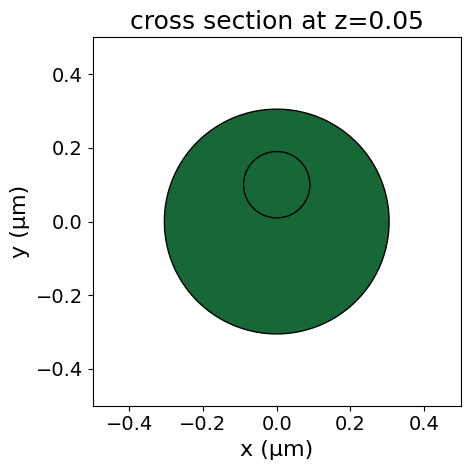

In [6]:
#--------------------------<< Si Main Cylinder >>--------------------------------
x0_1 = 0
y0_1 = 0
#--------------------------<< Air Main Cylinder >>--------------------------------
x0_2 = 0
y0_2 = delta
#--------------------------<< Number of Points >>----------------------------------
n = 500
#--------------------------<< Geometry Topology  >>--------------------------------
nanodisk_1 = td.Structure(
    geometry=td.PolySlab(
        vertices=Meta_atom(x0_1, y0_1, R, n), axis=2, slab_bounds=(0, h)
    ),
    medium=silicon,
)
nanodisk_2 = td.Structure(
    geometry=td.PolySlab(
        vertices=Meta_atom(x0_2, y0_2, rh, n), axis=2, slab_bounds=(0, h)
    ),
    medium=Air,
)
#-----------------------<< Create the substrate structure>>-------------------------------
inf_eff = 1e2
substrate = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=SiO2,
)
#--------------------------<< Plot the Meta Atom shape  >>--------------------------------
ax = nanodisk_1.plot(z=0.5*h)
nanodisk_2.plot(z=0.5*h, ax=ax)
ax.set_xlim(-px / 2, px / 2)
ax.set_ylim(-py / 2, py / 2)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
ax.set_aspect("equal", adjustable="box")
ax.set_title(ax.get_title(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.tick_params(axis='both', labelsize=14)
plt.show()

In [7]:
#------------------------- << simulation domain size in z >>------------------------------
Lz = 3*lam2
#------------------------------ << Monitor z position >>----------------------------------
monitor_z =Lz/2.5
#----------------------- << Define Transmission Flux Monitor>>----------------------------
T_Monitor = td.FluxMonitor(
    center=[0, 0, -monitor_z], size=[td.inf, td.inf, 0], freqs=freqs, name="T"
)
#---------------- << Define Reflection Flux Monitor: Can be Changed >>--------------------
R_Monitor = td.FluxMonitor(
    center=[0, 0, monitor_z], size=[td.inf, td.inf, 0], freqs=freqs, name="R"
)

# Finite Metasurface

In [14]:
lambda_sel_um = 1
print(wavelengths)
print(lambda_sel_um)
print(np.argmin(np.abs(wavelengths - lambda_sel_um)))

[1.52   1.5202 1.5204 1.5206 1.5208 1.521  1.5212 1.5214 1.5216 1.5218
 1.522  1.5222 1.5224 1.5226 1.5228 1.523  1.5232 1.5234 1.5236 1.5238
 1.524  1.5242 1.5244 1.5246 1.5248 1.525  1.5252 1.5254 1.5256 1.5258
 1.526  1.5262 1.5264 1.5266 1.5268 1.527  1.5272 1.5274 1.5276 1.5278
 1.528  1.5282 1.5284 1.5286 1.5288 1.529  1.5292 1.5294 1.5296 1.5298
 1.53   1.5302 1.5304 1.5306 1.5308 1.531  1.5312 1.5314 1.5316 1.5318
 1.532  1.5322 1.5324 1.5326 1.5328 1.533  1.5332 1.5334 1.5336 1.5338
 1.534  1.5342 1.5344 1.5346 1.5348 1.535  1.5352 1.5354 1.5356 1.5358
 1.536  1.5362 1.5364 1.5366 1.5368 1.537  1.5372 1.5374 1.5376 1.5378
 1.538  1.5382 1.5384 1.5386 1.5388 1.539  1.5392 1.5394 1.5396 1.5398
 1.54  ]
1
0


Plotting field at λ ≈ 1.5324 µm  (f ≈ 195.636 THz)


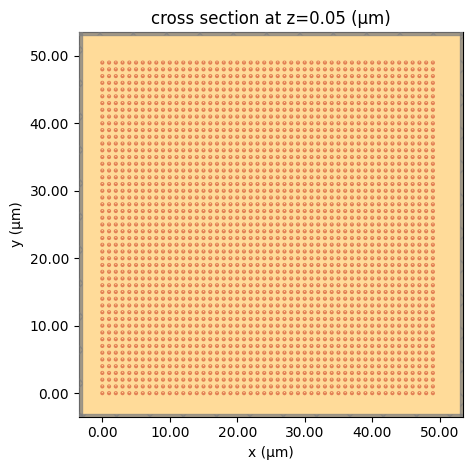

In [8]:
#--------------------------<< Number of Meta-Atoms in the x direction >>----------------------------------------
Nx = 50
#--------------------------<< Number of Meta-Atoms in the y direction >>----------------------------------------
Ny = 50
#-----------------------------------<< Choosing the Wavelength >>-----------------------------------------------
lambda_sel_um = 1.5325
idx = int(np.argmin(np.abs(wavelengths - lambda_sel_um)))
lambda_used_um = float(wavelengths[idx])
f_sel = float(freqs[idx])
print(f"Plotting field at λ ≈ {lambda_used_um:.4f} µm  (f ≈ {f_sel/1e12:.3f} THz)")
#-----------------------------<< Buffer Spacing in the x and y Directions >>------------------------------------
buffer = 2 * lambda_used_um
#-----------------------------------<< Simulation Domain Size >>-----------------------------------------------
Lx, Ly, Lz = Nx*px+2*buffer,Ny*py+2 * buffer, 3 * lambda_used_um
sim_size = [Lx, Ly, Lz]
# systematically construct the silicon resonators
metasurface = [substrate]

for i in range(Nx):
    for j in range(Ny):
        cylinder = td.Structure(
            geometry=td.Cylinder(center=[i * px, j * py, h / 2], radius=R, length=h, axis=2),
            medium=silicon,
        )
        metasurface.append(cylinder)

for i in range(Nx):
    for j in range(Ny):
        cylinder = td.Structure(
            geometry=td.Cylinder(center=[i * px, delta+(j * py), h / 2], radius=rh, length=h, axis=2),
            medium=Air,
        )
        metasurface.append(cylinder)

gaussian = td.GaussianBeam(
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=f_sel, fwidth=0.5 * freqw),
    center=(px * (Nx // 2), py * (Ny // 2), lambda_used_um),
    direction="-",
    waist_radius=10* lambda_used_um,
)

# define a field monitor to visualize the field distribution under gaussian beam excitation
monitor_field = td.FieldMonitor(
    center=[0, 0, h/2], size=[td.inf, td.inf, 0], freqs=[f_sel], name="field"
)

sim = td.Simulation(
    size=sim_size,
    center=(px * (Nx // 2), py * (Ny // 2), 0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=Mesh, wavelength= lambda_used_um),
    structures=metasurface,
    sources=[gaussian],
    monitors=[T_Monitor,R_Monitor,monitor_field],  # we will reuse the flux monitors defined earlier
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),  # pml is applied in all boundaries
    symmetry=(0, 0, 0),
)

sim.plot(z=h/2)
plt.show()
sim.plot_3d()

In [62]:
sim_data = web.run(
    sim,
    task_name="Finite_Metasurface",
    path="data/simulation.hdf5",
    verbose=True,
)

19:34:45 Eastern Daylight Time Created task 'Finite_Metasurface' with task_id   
                               'fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=814260;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=257087;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\taskId]8;;\
                               ]8;id=814260;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\=]8;;\]8;id=237111;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\fdve]8;;\]8;id=814260;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\-d5684ce6-ee6e-42a5-af7b-3c43750a74ac']8;;\.

                               Task folder: ]8;id=609795;https://tidy3d.simulation.cloud/folders/folder-a490576e-3e8b-4f7b-a2bc-dc9c69c79bac\'default']8;;\.

Output()

19:35:03 Eastern Daylight Time Maximum FlexCredit cost: 46.452. Minimum cost    
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

19:35:04 Eastern Daylight Time status = queued

                               To cancel the simulation, use                    
                               'web.abort(task_id)' or 'web.delete(task_id)' or 
                               abort/delete the task in the web UI. Terminating 
                               the Python script will not stop the job running  
                               on the cloud.

Output()

19:35:17 Eastern Daylight Time status = preprocess

19:35:51 Eastern Daylight Time starting up solver

                               running solver

Output()

19:42:35 Eastern Daylight Time early shutoff detected at 48%, exiting.

                               status = postprocess

Output()

19:42:56 Eastern Daylight Time status = success

19:42:58 Eastern Daylight Time View simulation result at                        
                               ]8;id=448173;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=732387;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\taskId]8;;\
                               ]8;id=448173;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\=]8;;\]8;id=38147;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\fdve]8;;\]8;id=448173;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5684ce6-ee6e-42a5-af7b-3c43750a74ac\-d5684ce6-ee6e-42a5-af7b-3c43750a74ac']8;;\.

Output()

19:44:03 Eastern Daylight Time loading simulation from data/simulation.hdf5

In [63]:
# web.real_cost("all_dielectric_metasurface_absorber")

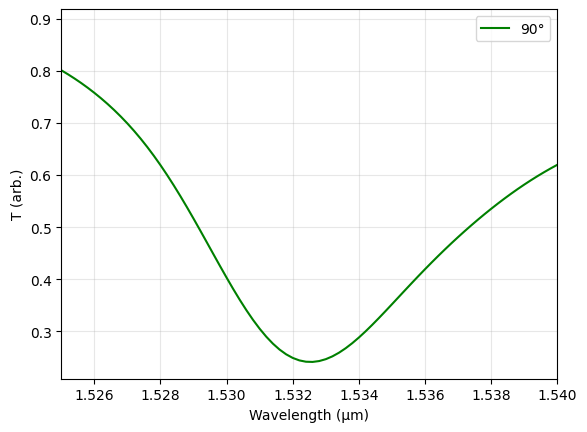

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td

R = sim_data["R"].flux
T = -sim_data["T"].flux  # if you really want the negative

# convert freq→wavelength (µm)
wavelengths_um = (td.C_0 / T.f.values)
Tvals = T.values

# sort so wavelength increases left→right
idx = np.argsort(wavelengths_um)
wavelengths_um = wavelengths_um[idx]
Tvals = Tvals[idx]

plt.plot(wavelengths_um, Tvals, color="green", label="90°")
plt.xlim(1.525, 1.54)           # <-- zoom window in µm
plt.xlabel("Wavelength (µm)")
plt.ylabel("T (arb.)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


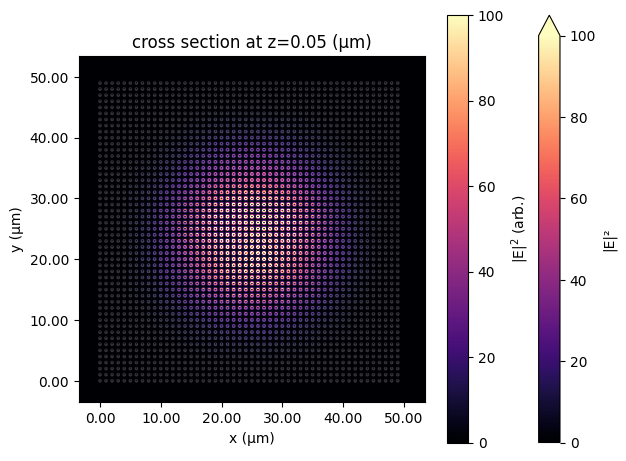

In [75]:
import matplotlib.pyplot as plt

# --- your knobs ---
vmin, vmax   = 0, 100            # manual color limits
cmap_name    = "magma"         # try: "magma", "turbo", "viridis", "cividis", "plasma", "RdBu_r"

ax = sim_data.plot_field(
    field_monitor_name="field",
    field_name="E",
    val="abs^2",
    vmin=vmin,
    vmax=vmax,
    shading="auto",
)

# grab the QuadMesh that carries the image and set the colormap
qm = next(c for c in ax.collections if hasattr(c, "get_array"))
qm.set_cmap(cmap_name)

# colorbar
plt.colorbar(qm, ax=ax, label=r"|E|$^2$ (arb.)")
plt.show()
